### <html><div align='center'> CrymeClassifiers Hyperparameter Tuning / Minor Feature Engineering
   </div></html>

In [186]:
n = 100
start_lon = 34.300779
end_lon = 33.749713
start_lat = -118.155360
end_lat = -118.666218
delta_lon = (end_lon - start_lon) / n
delta_lat = (end_lat - start_lat) / n

In [226]:
features_ = []
for row in range(0, n):
    for col in range(0, n):
        top_lft_lon = start_lon + row * delta_lon
        top_lft_lat = start_lat + col * delta_lat
        feat_dict = {
            "type":"Feature",
            "id":str(top_lft_lon + delta_lon/2) + '_' + str(top_lft_lat + delta_lat/2),
            "properties": {"name": str(row) + '_' + str(col)}
        }
        
        coordinates = [[
            [top_lft_lat, top_lft_lon],
            [top_lft_lat + delta_lat, top_lft_lon],
            [top_lft_lat + delta_lat, top_lft_lon + delta_lon],
            [top_lft_lat, top_lft_lon + delta_lon],
        ]]
        
        feat_dict["geometry"] = {
            "type":"Polygon",
            "coordinates": coordinates
        }
        features_.append(feat_dict)

        
la_grid_geo = {
    "type":"FeatureCollection",
    "features": features_,
}

        

In [229]:
point_ids = [z['id'] for z in la_grid_geo['features']]
points = [[float(i) for i in j.split('_')] for j in point_ids]
points = [i + [60.0] for i in points]
points = np.array(points)
crime_risk = pd.DataFrame({'id': point_ids, 'risk': rfc.predict_proba(points)[:,1]})

In [230]:
# Import libraries
import os
import pandas as pd
import folium
 
# Initialize the map:
m = folium.Map(location=[34.061545, -118.322877], zoom_start=11)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=la_grid_geo,
 name='choropleth',
 data=crime_risk,
 columns=['id', 'risk'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.5,
 line_opacity=0.01,
 legend_name='Theft Risk (%)'
)
folium.LayerControl().add_to(m)
m

/home/ben/.envs/cc/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [231]:
from datetime import datetime, timedelta
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from utils import assign_coordinate_to_lon_box, assign_coordinate_to_lat_box
import numpy as np

In [197]:
ts_start = str(datetime(year=2018, month=4, day=30))
ts_end = str(datetime(year=2019, month=4, day=1))

In [198]:
data = pd.read_csv('/home/ben/.envs/cc/CrymeClarity/crymepipelines/src/tmp/complete_dataset.csv')
data['hour'] = data['time_minutes'].apply(lambda x: round(x/60))
train_ds = data[(data.timestamp > ts_start) & (data.timestamp < ts_end)]
test_ds = data[(data.timestamp > ts_end)]

features = ['longitude', 'latitude', 'time_minutes']

##### Theft  CC

Our three parameters will be max_depth, learning_rate and num_leaves. Lets take the greedy approach to tuning them.

In [212]:
target = 'n_t'

In [213]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    print(iter_n)
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


0
{'max_depth': 2, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}


KeyboardInterrupt: 

In [ ]:
print(final[1], use_vals)

In [214]:
params = {
    'max_depth': 2, 
    'objective': 'binary', 
    'boosting_type': 'gbdt', 
    'learning_rate': 0.778, 
    'num_leaves': 80
}

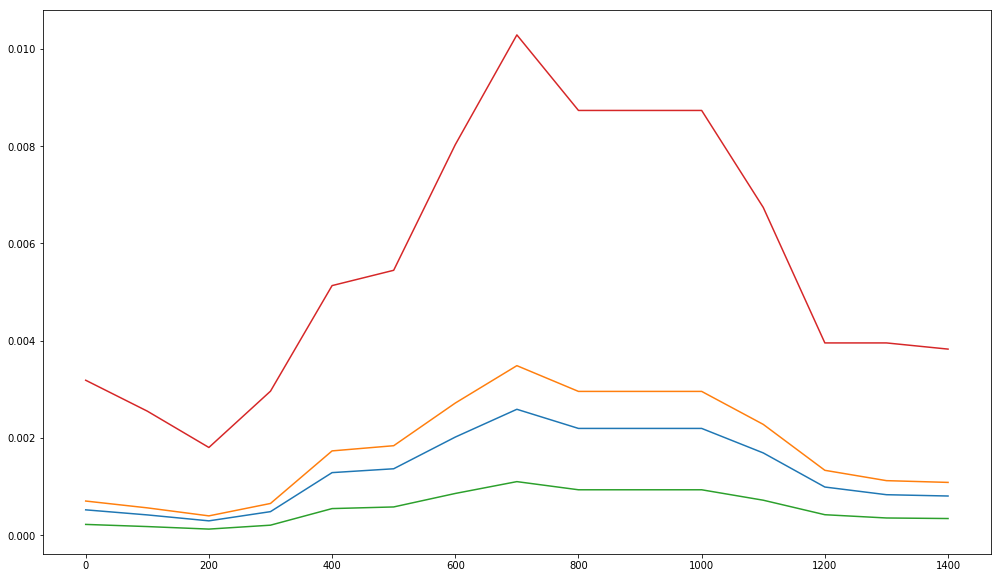

In [215]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 150)
lats = np.linspace(-118.666218, -118.155360, 150)
grid = []
for lon in lons:
    for lat in lats:
        grid.append([lon, lat, 800])
grid = np.array(grid)
grid[:,2] = rfc.predict_proba(grid)[:,1]
lat = grid[:,1].copy()
lon = grid[:,0].copy()


In [ ]:
hd = data[data['n_t']>0]

In [ ]:
import folium
from folium.plugins import HeatMap

def generateBaseMap(default_location=[34.039822, -118.335196], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()

In [ ]:
HeatMap(data=hd[['longitude', 'latitude', 'n_t']].values.tolist(), radius=5, max_zoom=11).add_to(base_map)

In [ ]:
base_map

#### Burglary CC

In [223]:
target = 'n_b'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [224]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": .445,
    "num_leaves": 10,
}

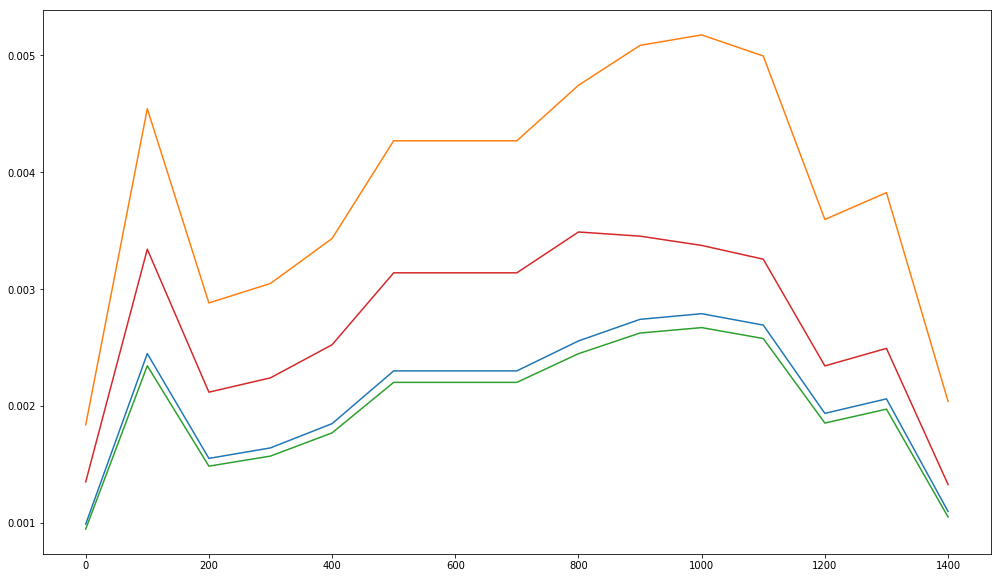

In [225]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Assault / Battery CC

In [166]:
target = 'n_ab'

In [167]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


{'max_depth': 2, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 3, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 4, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 5, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 6, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 7, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 8, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 9, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 10, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}


KeyboardInterrupt: 

In [168]:
print(final[1], use_vals)

IndexError: list index out of range

In [169]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 1.0,
    "num_leaves": 30,
}

In [170]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
y_est = rfc.predict_proba(test_ds[features])

log_loss(test_ds[target], y_est)

0.016579061140409565

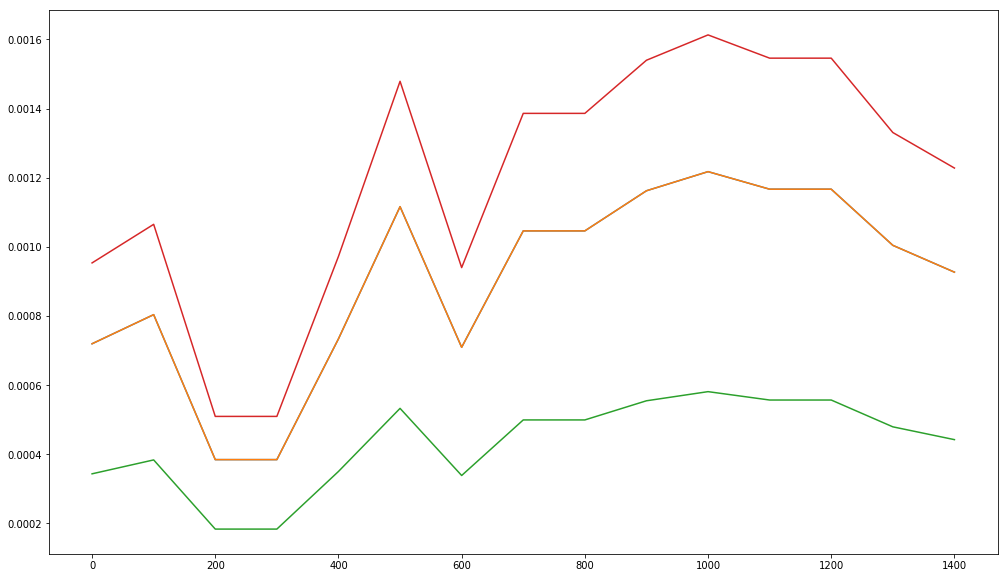

In [171]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Life-Threatening Violent Crime CC

In [ ]:
target = 'n_ltvc'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.445,
    "num_leaves": 10,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Shoplifting / Pickpocketing CC

In [206]:
target = 'n_sp'

In [200]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


{'max_depth': 2, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}
{'max_depth': 3, 'objective': 'binary', 'boosting_type': 'gbdt', 'learning_rate': 0.001, 'num_leaves': 10}


KeyboardInterrupt: 

In [ ]:
print(final[1], use_vals)

In [207]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.889,
    "num_leaves": 20,
}

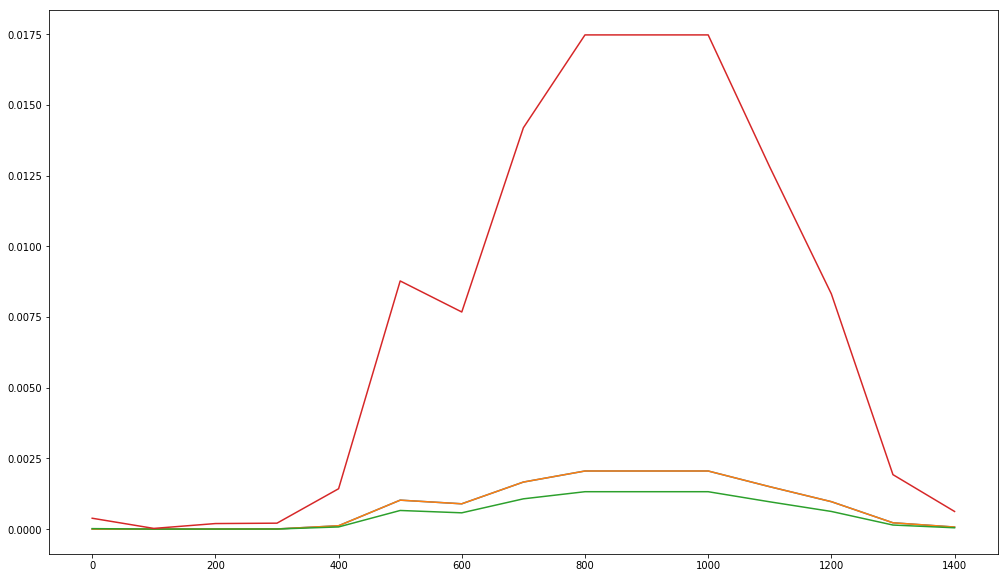

In [208]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.056955, -118.419148, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
grid[100][400]

In [ ]:
lons = np.linspace(34.063200,34.054860, 1000)
lats = np.linspace(-118.423490, -118.412656, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 1400])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Vehicle/Bike/Boat Stolen CC

In [ ]:
target = 'n_vbbs'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1, 10),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 1.0,
    "num_leaves": 160,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Property Damage / Threats CC

In [ ]:
target = 'n_pdt'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1.3, 12),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.47336,
    "num_leaves": 10,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Burglary / Theft From Vehicle CC

In [ ]:
target = 'n_btv'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1.3, 12),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.47336363636363643,
    "num_leaves": 10,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
data[(data.latitude < -118.554528) & (data.longitude < 34.037846) & (data.n_btv>0)]

In [ ]:
grid[500][135]

In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

#### Misc. Infrequent Offenses CC

In [ ]:
target = 'n_mio'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1.3, 12),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.355273,
    "num_leaves": 10,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()

In [ ]:
grid[650][115]

In [ ]:
im[650][115]

#### Robbery (Violent Theft) CC

In [ ]:
target = 'n_r'

In [ ]:
tuning = {
    'max_depth': list(range(2,11)),
    'learning_rate': np.linspace(0.001,1.3, 12),
    'num_leaves': list(range(10,200, 10)),
}
use_vals = {
    'max_depth': tuning['max_depth'][0],
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": tuning['learning_rate'][0],
    "num_leaves": tuning['num_leaves'][0]

}
final = []
for iter_n in range(0, 3):
    lls = []
    trial_settings = []
    for param in tuning:
        for comp in tuning[param]:
            test_params = use_vals.copy()
            test_params[param] = comp
            print(test_params)
            rfc = LGBMClassifier(**test_params)
            rfc.fit(train_ds[features], train_ds[target])
            y_est = rfc.predict_proba(test_ds[features])
            lls.append(log_loss(test_ds[target], y_est))
            trial_settings.append(test_params)
    use_vals = trial_settings[lls.index(min(lls))]
    print('settling on ..')
    print(use_vals)
    final.append(min(lls))


In [ ]:
print(final[1], use_vals)

In [ ]:
params = {
    'max_depth': 2,
    "objective": "binary",
    "boosting_type": "gbdt",
    "learning_rate": 0.355273,
    "num_leaves": 10,
}

In [ ]:
rfc = LGBMClassifier(**params)
rfc.fit(train_ds[features], train_ds[target])
plt.figure(figsize=(17,10))
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.064540, -118.437803, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.062533, -118.445334, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.067404, -118.433251, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)
tst = []
for i in range(0, 1440, 100):
    tst.append(rfc.predict_proba([[34.0762515879397, -118.37382875376885, i]])[0][1])
plt.plot(range(0, 1440, 100), tst)


In [ ]:
lons = np.linspace(34.300779,33.749713, 1000)
lats = np.linspace(-118.666218, -118.155360, 1000)
grid = []
for lon in lons:
    row  = []
    for lat in lats:
        row.append([lon, lat, 800])
    grid.append(row)
im = []
for row in grid:
    im.append(rfc.predict_proba(np.array(row))[:,1])
    
plt.figure(figsize=(17,10))

plt.imshow((im - np.average(im))/np.sqrt(np.var(im)), interpolation='none')
plt.show()